In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import datasets, layers, models
from keras.preprocessing.text import Tokenizer
from konlpy.tag import Okt
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import concatenate
import re

Using TensorFlow backend.


# 데이터 불러오기
- FastText
- 네이버 영화 리뷰

In [2]:
from gensim import models

#https://fasttext.cc/docs/en/crawl-vectors.html , Fasttext 한국어 모델 파일 다운로드
ko_model = models.fasttext.load_facebook_model('cc.ko.300.bin.gz')

In [3]:
# 네이버 영화 리뷰 불러오기
df = pd.read_excel('ratings_train.xlsx')

# 영화리뷰와 라벨 분리
doc = list(df['document'])
labels = list(df['label'])

# 영화 리뷰 전처리 X
- 전처리를 하지 않고 한글만 추출

In [4]:
unprocessed = []
for sentence in doc:
    try:
        unprocessed.append(re.findall('[가-힣]+', sentence))
    except:
        unprocessed.append('아')

In [5]:
unprocessed[:10]

[['아', '더빙', '진짜', '짜증나네요', '목소리'],
 ['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나'],
 ['너무재밓었다그래서보는것을추천한다'],
 ['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정'],
 ['사이몬페그의',
  '익살스런',
  '연기가',
  '돋보였던',
  '영화',
  '스파이더맨에서',
  '늙어보이기만',
  '했던',
  '커스틴',
  '던스트가',
  '너무나도',
  '이뻐보였다'],
 ['막', '걸음마', '뗀', '세부터', '초등학교', '학년생인', '살용영화', '별반개도', '아까움'],
 ['원작의', '긴장감을', '제대로', '살려내지못했다'],
 ['별',
  '반개도',
  '아깝다',
  '욕나온다',
  '이응경',
  '길용우',
  '연기생활이몇년인지',
  '정말',
  '발로해도',
  '그것보단',
  '낫겟다',
  '납치',
  '감금만반복반복',
  '이드라마는',
  '가족도없다',
  '연기못하는사람만모엿네'],
 ['액션이', '없는데도', '재미', '있는', '몇안되는', '영화'],
 ['왜케', '평점이', '낮은건데', '꽤', '볼만한데', '헐리우드식', '화려함에만', '너무', '길들여져', '있나']]

# 영화 리뷰 전처리
- 어간 추출 & 조사, 어미, 구두점 제외
- 불용어처리

In [6]:
okt = Okt()

In [7]:
clean_doc = []
error_list = []
for i, document in enumerate(doc):
    clean_words = []
    try:
        for word in okt.pos(document, stem=True): #어간 추출
            if word[1] not in ['Josa', 'Eomi', 'Punctuation']: #조사, 어미, 구두점 제외 
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        clean_doc.append(document)
    except:
        #결측치를 '아'로 처리
      clean_doc.append('아')
      error_list.append(document)

In [8]:
print('결측치 개수: ',len(error_list))
print('결측치 예시: ', error_list[:10])

결측치 개수:  115
결측치 예시:  [1, 4, 4, 1236547890, 1, nan, 3.6, nan, 2.6, 1]


In [8]:
nltk.download('punkt')
stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하']

for i, document in enumerate(clean_doc):
    clean_words = [] 
    for word in nltk.tokenize.word_tokenize(document): 
        if word not in stopwords: #불용어 제거
            clean_words.append(word)   
    clean_doc[i] = ' '.join(clean_words)        

clean_doc[:10]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['아 더빙 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 오버 연기 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 다',
 '교도소 이야기 구먼 솔직하다 재미 없다 평점 조정',
 '사이 몬페 의 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트 너무나도 이쁘다 보이다',
 '막 걸음 마 떼다 3 세 초등학교 1 학년 생인 8 살다 영화 ㅋㅋㅋ 별 반개 아깝다 움',
 '원작 긴장감 제대로 살리다 하다',
 '별 반개 아깝다 욕 나오다 이응경 길용우 연 기 생활 몇 정말 발 해도 그것 낫다 납치 감금 반복 반복 드라마 가족 없다 연기 못 하다 모 엿 네',
 '액션 없다 재미 있다 몇 안되다 영화',
 '왜케 평점 낮다 꽤 볼 데 헐리우드 식 화려하다 너무 길들이다 있다']

# 토크나이즈 (전처리 X)

문장의 최대 길이: 47 
 임베딩 매트릭스 형태:  (278263, 300)


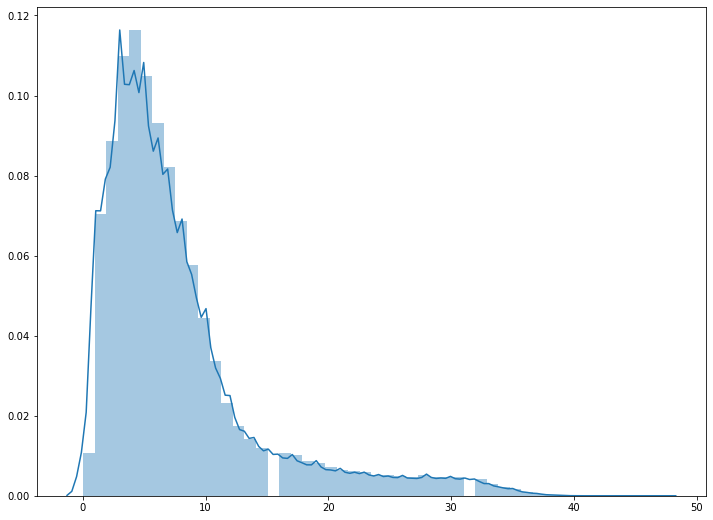

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(unprocessed)
vocab_size = len(tokenizer.word_index) + 1

X_encoded = tokenizer.texts_to_sequences(unprocessed)
max_len = max(len(I) for I in X_encoded)

# 문장 내 단어의 길이 확인
count_len = pd.Series(X_encoded).apply(len)

plt.figure(figsize=(12,9))
sns.distplot(count_len)

# 문장 내 단어의 길이 정규화(nomalize)
X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(labels)

VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = ko_model.wv.word_vec(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
print('문장의 최대 길이:', max_len ,'\n','임베딩 매트릭스 형태: ', embedding_matrix.shape)

In [11]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
non_pre_model = tf.keras.Model(sequence_input, output)
non_pre_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 47, 300)      83478900    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 47, 128)      115328      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 47, 128)      153728      embedding[0][0]                  
_______________________________________________________________________________________

In [12]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

non_pre_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

non_pre_history = non_pre_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6870 - accuracy: 0.5950 - val_loss: 0.6458 - val_accuracy: 0.6514
Epoch 2/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6274 - accuracy: 0.6867 - val_loss: 0.6059 - val_accuracy: 0.7078
Epoch 3/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5822 - accuracy: 0.7459 - val_loss: 0.6123 - val_accuracy: 0.7113
Epoch 4/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5400 - accuracy: 0.7913 - val_loss: 0.6050 - val_accuracy: 0.7305
Epoch 5/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5009 - accuracy: 0.8286 - val_loss: 0.6206 - val_accuracy: 0.7350
Epoch 6/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.4593 - accuracy: 0.8615 - val_loss: 0.6625 - val_accuracy: 0.7345
Epoch 7/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.4179 - accuracy: 0.8884 - val_loss: 0.7099 - val_ac

# 토크나이즈 (전처리 O)

## 최대 길이 지정 X

문장의 최대 길이:67
임베딩 매트릭스 형태:(47192, 300) 


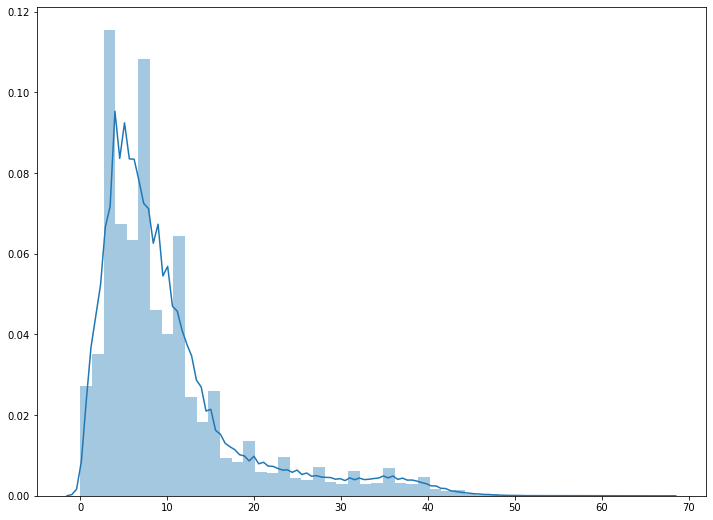

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_doc)
vocab_size = len(tokenizer.word_index) + 1

X_encoded = tokenizer.texts_to_sequences(clean_doc)
max_len = max(len(I) for I in X_encoded)

# 단어의 최대 길이 확인
count_len = pd.Series(X_encoded).apply(len)
plt.figure(figsize=(12,9))
sns.distplot(count_len)

#빈도수를 평준화하기 위해서 max_len 값을 조절

X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(labels)

import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = ko_model.wv.word_vec(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
print('문장의 최대 길이:{}'.format(max_len),'임베딩 매트릭스 형태:{} '.format(embedding_matrix.shape), sep='\n')

In [13]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
max_len_max_model = tf.keras.Model(sequence_input, output)
max_len_max_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 47, 300)      83478900    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 47, 128)      115328      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 47, 128)      153728      embedding_1[0][0]                
_______________________________________________________________________________________

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

max_len_max_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

max_len_max_history = max_len_max_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6918 - accuracy: 0.5681 - val_loss: 0.6475 - val_accuracy: 0.6441
Epoch 2/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6430 - accuracy: 0.6476 - val_loss: 0.6145 - val_accuracy: 0.6851
Epoch 3/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6062 - accuracy: 0.6961 - val_loss: 0.5858 - val_accuracy: 0.7169
Epoch 4/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5711 - accuracy: 0.7365 - val_loss: 0.5817 - val_accuracy: 0.7246
Epoch 5/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5379 - accuracy: 0.7675 - val_loss: 0.5758 - val_accuracy: 0.7332
Epoch 6/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5047 - accuracy: 0.7975 - val_loss: 0.5896 - val_accuracy: 0.7333
Epoch 7/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.4702 - accuracy: 0.8213 - val_loss: 0.6111 - val_ac

In [21]:
def find_length(document):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(document)
    vocab_size = len(tokenizer.word_index) + 1

    X_encoded = tokenizer.texts_to_sequences(document)
    max_len = max(len(I) for I in X_encoded)

    # 단어의 최대 길이 확인
    count_len = pd.Series(X_encoded).apply(len)
    plt.figure(figsize=(12,9))
    sns.distplot(count_len)
    print('문장의 최대길이:',max_len)
    
    return X_encoded, max_len

문장의 최대길이:  67


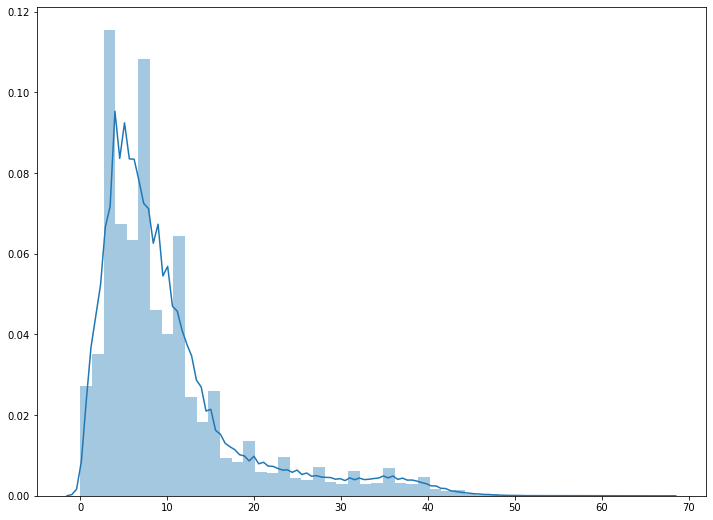

In [22]:
X_encoded, max_len = find_length(clean_doc)

In [28]:
def model_training(encoded, maxlen, dropout, l2):

    #빈도수를 평준화하기 위해서 max_len 값을 조절
    X_train = pad_sequences(encoded, maxlen=maxlen, padding='post')
    y_train = np.array(labels)

    VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
    EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

    for word, idx in tokenizer.word_index.items():
        embedding_vector = ko_model.wv.word_vec(word) #패스트텍스트모델
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    sequence_input = tf.keras.Input(shape=(maxlen,), dtype='int32')
    embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                                EMBEDDING_DIM,
                                input_length=maxlen,
                                trainable=False)
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    #각각의 N-gram을 통해 생성된 layer를 담는 곳
    filter_sizes = [3,4,5]
    #filter_size는 N-gram에서의 N을 결정

    for fsz in filter_sizes:
        x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
        x = tf.keras.layers.MaxPooling1D()(x)
        convs.append(x)

    x = tf.keras.layers.Concatenate(axis=-1)(convs)
    
    #3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    
    # l2 규제를 조절
    x = tf.keras.layers.Dropout(dropout)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    #해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
    model = tf.keras.Model(sequence_input, output)
    model.summary()

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    #val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model_history = model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])
    return model_history

In [29]:
model_history = model_training(X_encoded, max_len, 0.5, 0.02)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 67, 300)      83478900    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 67, 128)      115328      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 67, 128)      153728      embedding_3[0][0]                
_______________________________________________________________________________________

# GridSearch

- 문장의 최대 길이 , Dropout, L2 규제 값을 조절하여 최적의 파라미터 산출

In [ ]:
best_score = 0

maxlen_param = [30, 40, 50]
dropout_param = [0.1, 0.2, 0.3, 0.4, 0.5]
l2_param = [0.001, 0.01, 0.1, 1, 10, 100]

for m in maxlen_param:
    for d in dropout_param:
        for l in l2_param:
            model_history = model_training(X_encoded, m, d, l)
            score = max(model_history.history['val_accuracy'])
            if score > best_score:
                best_score = score
                best_param = {'Maxlen' : m, 'Dropout' : d, 'L2' : l}
    
print('best score ==> {:.3f}'.format(best_score))
print('best parameter ==> {}'.format(best_parameter))

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 300)      83478900    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 30, 128)      115328      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 30, 128)      153728      embedding_4[0][0]                
_______________________________________________________________________________________

3750/3750 [==============================] - 12s 3ms/step - loss: 0.3346 - accuracy: 0.9045 - val_loss: 0.5137 - val_accuracy: 0.8244
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.2974 - accuracy: 0.9259 - val_loss: 0.5631 - val_accuracy: 0.8130
Epoch 7/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.2686 - accuracy: 0.9394 - val_loss: 0.6275 - val_accuracy: 0.8118
Epoch 8/10
3750/3750 [==============================] - 13s 3ms/step - loss: 0.2446 - accuracy: 0.9510 - val_loss: 0.6308 - val_accuracy: 0.8152
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_6 

3750/3750 [==============================] - 13s 3ms/step - loss: 1.2999 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 13s 3ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.5027
Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_8 

3750/3750 [==============================] - 13s 3ms/step - loss: 0.7008 - accuracy: 0.4991 - val_loss: 0.6980 - val_accuracy: 0.5027
Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 30, 300)      83478900    input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 30, 128)      115328      embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 30, 128)    

3750/3750 [==============================] - 12s 3ms/step - loss: 0.4190 - accuracy: 0.8509 - val_loss: 0.4650 - val_accuracy: 0.8233
Epoch 4/10
3750/3750 [==============================] - 13s 3ms/step - loss: 0.3802 - accuracy: 0.8801 - val_loss: 0.4834 - val_accuracy: 0.8226
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3414 - accuracy: 0.9040 - val_loss: 0.5244 - val_accuracy: 0.8149
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3060 - accuracy: 0.9248 - val_loss: 0.5667 - val_accuracy: 0.8184
Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_12

3750/3750 [==============================] - 12s 3ms/step - loss: 1.2993 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4973
Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_14

3750/3750 [==============================] - 12s 3ms/step - loss: 61.4199 - accuracy: 0.4977 - val_loss: 0.6973 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6971 - accuracy: 0.4999 - val_loss: 0.6973 - val_accuracy: 0.4973
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6971 - accuracy: 0.4980 - val_loss: 0.6970 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6970 - accuracy: 0.4999 - val_loss: 0.6970 - val_accuracy: 0.4973
Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_1

3750/3750 [==============================] - 12s 3ms/step - loss: 0.5573 - accuracy: 0.7494 - val_loss: 0.4993 - val_accuracy: 0.7992
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4727 - accuracy: 0.8193 - val_loss: 0.4835 - val_accuracy: 0.8142
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4361 - accuracy: 0.8504 - val_loss: 0.4778 - val_accuracy: 0.8259
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4040 - accuracy: 0.8766 - val_loss: 0.5148 - val_accuracy: 0.8231
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3704 - accuracy: 0.9008 - val_loss: 0.5289 - val_accuracy: 0.8221
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3380 - accuracy: 0.9213 - val_loss: 0.5780 - val_accuracy: 0.8129
Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)       

3750/3750 [==============================] - 12s 3ms/step - loss: 1.3006 - accuracy: 0.5000 - val_loss: 0.6943 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6579 - accuracy: 0.6462 - val_loss: 0.6110 - val_accuracy: 0.7138
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6118 - accuracy: 0.7140 - val_loss: 0.5812 - val_accuracy: 0.7503
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.5901 - accuracy: 0.7453 - val_loss: 0.5802 - val_accuracy: 0.7498
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.5792 - accuracy: 0.7635 - val_loss: 0.5480 - val_accuracy: 0.7833
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.5693 - accuracy: 0.7802 - val_loss: 0.5489 - val_accuracy: 0.7840
Epoch 7/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.5634 - accuracy: 0.7928 - val_loss: 0.5548 - val_accuracy: 0.8

3750/3750 [==============================] - 12s 3ms/step - loss: 61.4602 - accuracy: 0.4998 - val_loss: 0.6970 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6973 - accuracy: 0.4988 - val_loss: 0.6977 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6979 - accuracy: 0.5008 - val_loss: 0.6982 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6980 - accuracy: 0.4993 - val_loss: 0.6977 - val_accuracy: 0.5027
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6979 - accuracy: 0.4977 - val_loss: 0.6981 - val_accuracy: 0.4973
Model: "functional_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 30)]         0          

3750/3750 [==============================] - 12s 3ms/step - loss: 0.4767 - accuracy: 0.8150 - val_loss: 0.4793 - val_accuracy: 0.8119
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4383 - accuracy: 0.8466 - val_loss: 0.4817 - val_accuracy: 0.8232
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.4038 - accuracy: 0.8744 - val_loss: 0.5054 - val_accuracy: 0.8214
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3695 - accuracy: 0.8987 - val_loss: 0.5239 - val_accuracy: 0.8198
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.3364 - accuracy: 0.9184 - val_loss: 0.5618 - val_accuracy: 0.8206
Model: "functional_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 30)]         0           

3750/3750 [==============================] - 12s 3ms/step - loss: 1.2995 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6932 - val_accuracy: 0.5027
Model: "functional_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_26

3750/3750 [==============================] - 11s 3ms/step - loss: 0.6972 - accuracy: 0.4979 - val_loss: 0.6972 - val_accuracy: 0.5027
Model: "functional_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_28 (Embedding)        (None, 30, 300)      83478900    input_29[0][0]                   
__________________________________________________________________________________________________
conv1d_84 (Conv1D)              (None, 30, 128)      115328      embedding_28[0][0]               
__________________________________________________________________________________________________
conv1d_85 (Conv1D)              (None, 30, 128)    

3750/3750 [==============================] - 11s 3ms/step - loss: 0.3657 - accuracy: 0.9152 - val_loss: 0.5823 - val_accuracy: 0.8164
Epoch 7/10
3750/3750 [==============================] - 11s 3ms/step - loss: 0.3369 - accuracy: 0.9317 - val_loss: 0.6319 - val_accuracy: 0.8176
Model: "functional_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 30, 300)      83478900    input_31[0][0]                   
__________________________________________________________________________________________________
conv1d_90 (Conv1D)              (None, 30, 128)      115328      embedding_30[0][0]               
_____

3750/3750 [==============================] - 12s 3ms/step - loss: 1.2998 - accuracy: 0.5008 - val_loss: 0.6935 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6874 - accuracy: 0.5739 - val_loss: 0.6441 - val_accuracy: 0.6863
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6541 - accuracy: 0.6722 - val_loss: 0.6303 - val_accuracy: 0.7121
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6397 - accuracy: 0.6953 - val_loss: 0.6418 - val_accuracy: 0.7013
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6300 - accuracy: 0.7129 - val_loss: 0.5785 - val_accuracy: 0.7727
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6265 - accuracy: 0.7249 - val_loss: 0.5710 - val_accuracy: 0.7846
Epoch 7/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.6189 - accuracy: 0.7397 - val_loss: 0.5612 - val_accuracy: 0.7

3750/3750 [==============================] - 12s 3ms/step - loss: 61.3111 - accuracy: 0.5008 - val_loss: 0.6977 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.7027 - accuracy: 0.4995 - val_loss: 0.6990 - val_accuracy: 0.5046
Epoch 3/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.7005 - accuracy: 0.5008 - val_loss: 0.7009 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.7010 - accuracy: 0.4985 - val_loss: 0.7009 - val_accuracy: 0.4973
Epoch 5/10
3750/3750 [==============================] - 12s 3ms/step - loss: 0.7009 - accuracy: 0.4992 - val_loss: 0.7010 - val_accuracy: 0.4973
Model: "functional_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 40)]         0          

3750/3750 [==============================] - 14s 4ms/step - loss: 0.4571 - accuracy: 0.8228 - val_loss: 0.4653 - val_accuracy: 0.8215
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4149 - accuracy: 0.8549 - val_loss: 0.4642 - val_accuracy: 0.8244
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3786 - accuracy: 0.8814 - val_loss: 0.5097 - val_accuracy: 0.8199
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3402 - accuracy: 0.9061 - val_loss: 0.5430 - val_accuracy: 0.8220
Epoch 6/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.3037 - accuracy: 0.9266 - val_loss: 0.5489 - val_accuracy: 0.8191
Model: "functional_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 40)]         0           

3750/3750 [==============================] - 14s 4ms/step - loss: 1.2321 - accuracy: 0.5044 - val_loss: 0.6943 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6470 - accuracy: 0.6624 - val_loss: 0.5867 - val_accuracy: 0.7331
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5947 - accuracy: 0.7324 - val_loss: 0.5748 - val_accuracy: 0.7506
Epoch 4/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5742 - accuracy: 0.7592 - val_loss: 0.5936 - val_accuracy: 0.7649
Epoch 5/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5612 - accuracy: 0.7769 - val_loss: 0.5785 - val_accuracy: 0.7662
Epoch 6/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5505 - accuracy: 0.7934 - val_loss: 0.5511 - val_accuracy: 0.8026
Epoch 7/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5438 - accuracy: 0.8067 - val_loss: 0.5676 - val_accuracy: 0.7

3750/3750 [==============================] - 15s 4ms/step - loss: 54.4579 - accuracy: 0.4989 - val_loss: 0.6994 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6995 - accuracy: 0.4992 - val_loss: 0.6998 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6998 - accuracy: 0.4990 - val_loss: 0.6998 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6998 - accuracy: 0.4988 - val_loss: 0.6997 - val_accuracy: 0.5027
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6998 - accuracy: 0.5004 - val_loss: 0.6998 - val_accuracy: 0.5027
Model: "functional_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 40)]         0          

3750/3750 [==============================] - 14s 4ms/step - loss: 0.5558 - accuracy: 0.7460 - val_loss: 0.4880 - val_accuracy: 0.8015
Epoch 2/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.4678 - accuracy: 0.8183 - val_loss: 0.4725 - val_accuracy: 0.8118
Epoch 3/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.4281 - accuracy: 0.8506 - val_loss: 0.4798 - val_accuracy: 0.8193
Epoch 4/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.3934 - accuracy: 0.8766 - val_loss: 0.4935 - val_accuracy: 0.8276
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3544 - accuracy: 0.9034 - val_loss: 0.5347 - val_accuracy: 0.8218
Epoch 6/10
3750/3750 [==============================] - 13s 3ms/step - loss: 0.3224 - accuracy: 0.9241 - val_loss: 0.6016 - val_accuracy: 0.8107
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.2932 - accuracy: 0.9385 - val_loss: 0.6265 - val_accuracy: 0.8

3750/3750 [==============================] - 14s 4ms/step - loss: 1.2314 - accuracy: 0.4993 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6851 - accuracy: 0.5622 - val_loss: 0.6270 - val_accuracy: 0.6926
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6170 - accuracy: 0.7130 - val_loss: 0.6001 - val_accuracy: 0.7317
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5935 - accuracy: 0.7456 - val_loss: 0.5822 - val_accuracy: 0.7658
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5805 - accuracy: 0.7684 - val_loss: 0.5911 - val_accuracy: 0.7652
Epoch 6/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5726 - accuracy: 0.7827 - val_loss: 0.5803 - val_accuracy: 0.7770
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5661 - accuracy: 0.7973 - val_loss: 0.5904 - val_accuracy: 0.7

3750/3750 [==============================] - 14s 4ms/step - loss: 54.6059 - accuracy: 0.5015 - val_loss: 0.6996 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6997 - accuracy: 0.4994 - val_loss: 0.7007 - val_accuracy: 0.4973
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7003 - accuracy: 0.4980 - val_loss: 0.7003 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7002 - accuracy: 0.5001 - val_loss: 0.7004 - val_accuracy: 0.5027
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7001 - accuracy: 0.4999 - val_loss: 0.7001 - val_accuracy: 0.5027
Epoch 6/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7002 - accuracy: 0.4976 - val_loss: 0.7001 - val_accuracy: 0.4973
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7002 - accuracy: 0.4992 - val_loss: 0.7004 - val_accuracy: 0.

3750/3750 [==============================] - 14s 4ms/step - loss: 0.5642 - accuracy: 0.7448 - val_loss: 0.4983 - val_accuracy: 0.7984
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4790 - accuracy: 0.8195 - val_loss: 0.4950 - val_accuracy: 0.8150
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4414 - accuracy: 0.8528 - val_loss: 0.4991 - val_accuracy: 0.8152
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4075 - accuracy: 0.8798 - val_loss: 0.5044 - val_accuracy: 0.8255
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3737 - accuracy: 0.9027 - val_loss: 0.5429 - val_accuracy: 0.8221
Epoch 6/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3409 - accuracy: 0.9234 - val_loss: 0.5987 - val_accuracy: 0.8185
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3139 - accuracy: 0.9387 - val_loss: 0.6226 - val_accuracy: 0.8

3750/3750 [==============================] - 14s 4ms/step - loss: 1.2321 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 6/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.4973
Model: "functional_101"
__________________________________________________________________________________________________
Layer (type)      

3750/3750 [==============================] - 14s 4ms/step - loss: 54.6268 - accuracy: 0.4982 - val_loss: 0.6999 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7003 - accuracy: 0.4997 - val_loss: 0.7008 - val_accuracy: 0.4973
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7037 - accuracy: 0.4963 - val_loss: 0.7010 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7063 - accuracy: 0.4970 - val_loss: 0.7013 - val_accuracy: 0.4973
Model: "functional_105"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_

3750/3750 [==============================] - 15s 4ms/step - loss: 0.5651 - accuracy: 0.7468 - val_loss: 0.5163 - val_accuracy: 0.7964
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4879 - accuracy: 0.8150 - val_loss: 0.4832 - val_accuracy: 0.8159
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4547 - accuracy: 0.8461 - val_loss: 0.4920 - val_accuracy: 0.8234
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4258 - accuracy: 0.8731 - val_loss: 0.5127 - val_accuracy: 0.8264
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3975 - accuracy: 0.8978 - val_loss: 0.5399 - val_accuracy: 0.8240
Epoch 6/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3659 - accuracy: 0.9170 - val_loss: 0.5839 - val_accuracy: 0.8173
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.3414 - accuracy: 0.9328 - val_loss: 0.6190 - val_accuracy: 0.8

3750/3750 [==============================] - 14s 4ms/step - loss: 1.2321 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4973
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5027
Model: "functional_113"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_5

In [33]:
max(model_history.history['val_accuracy'])

0.8238666653633118

## 최대 길이 50

문장의 최대 길이:50
임베딩 매트릭스 형태:(47192, 300) 


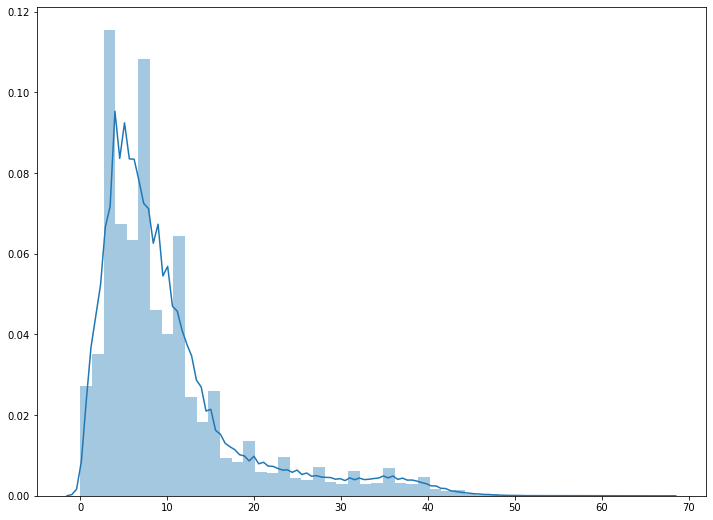

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_doc)
vocab_size = len(tokenizer.word_index) + 1

X_encoded = tokenizer.texts_to_sequences(clean_doc)
max_len = 50
# max_len = max(len(I) for I in X_encoded)

# 단어의 길이 빈도수 확인
count_len = pd.Series(X_encoded).apply(len)
plt.figure(figsize=(12,9))
sns.distplot(count_len)

#빈도수를 평준화하기 위해서 max_len 값을 조절

X_train = pad_sequences(X_encoded, maxlen=max_len, padding='post')
y_train = np.array(labels)

import numpy as np

VOCAB_SIZE = len(tokenizer.index_word) + 1 #1을 더해주는 것은 0으로 채운 padding 때문
EMBEDDING_DIM = 300 #Fasttext의 embedding_dimension = 300

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, idx in tokenizer.word_index.items():
    embedding_vector = ko_model.wv.word_vec(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        
print('문장의 최대 길이:{}'.format(max_len),'임베딩 매트릭스 형태:{} '.format(embedding_matrix.shape), sep='\n')

In [20]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
max_len_fifty_model = tf.keras.Model(sequence_input, output)
max_len_fifty_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      14157600    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 50, 128)      115328      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 50, 128)      153728      embedding_2[0][0]                
_______________________________________________________________________________________

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

max_len_fifty_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

max_len_fifty_history = max_len_fifty_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5975 - accuracy: 0.7284 - val_loss: 0.5228 - val_accuracy: 0.7885
Epoch 2/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5208 - accuracy: 0.8035 - val_loss: 0.5081 - val_accuracy: 0.8143
Epoch 3/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4943 - accuracy: 0.8333 - val_loss: 0.5123 - val_accuracy: 0.8231
Epoch 4/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4754 - accuracy: 0.8571 - val_loss: 0.5352 - val_accuracy: 0.8184
Epoch 5/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4555 - accuracy: 0.8764 - val_loss: 0.5364 - val_accuracy: 0.8252
Epoch 6/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4366 - accuracy: 0.8953 - val_loss: 0.5743 - val_accuracy: 0.8232
Epoch 7/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4142 - accuracy: 0.9122 - val_loss: 0.5963 - val_ac

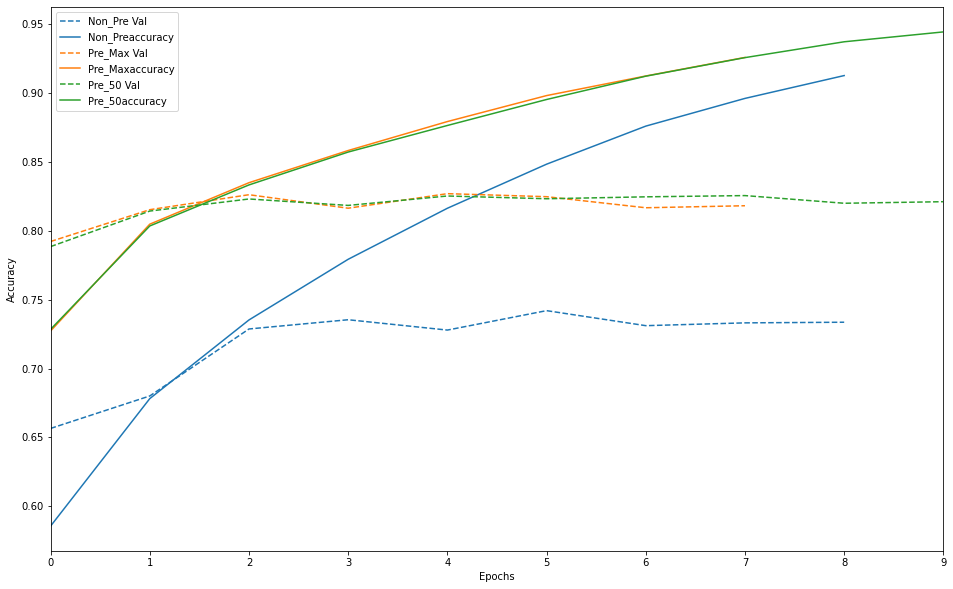

In [22]:
def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+ key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+ key)

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
    
    
plot_history([('Non_pre', non_pre_history),
              ('Pre_Max', max_len_max_history),
              ('Pre_50', max_len_fifty_history)])

# L2 규제 변경

### l2 0.2

In [23]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.2))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
l2_0_2_model = tf.keras.Model(sequence_input, output)
l2_0_2_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 50, 300)      14157600    input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 50, 128)      115328      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 50, 128)      153728      embedding_3[0][0]                
_______________________________________________________________________________________

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

l2_0_2_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

l2_0_2_history = l2_0_2_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.7560 - accuracy: 0.6259 - val_loss: 0.5879 - val_accuracy: 0.7290
Epoch 2/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5962 - accuracy: 0.7243 - val_loss: 0.5636 - val_accuracy: 0.7672
Epoch 3/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.5725 - accuracy: 0.7552 - val_loss: 0.5285 - val_accuracy: 0.7908
Epoch 4/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5580 - accuracy: 0.7724 - val_loss: 0.5114 - val_accuracy: 0.8030
Epoch 5/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5477 - accuracy: 0.7886 - val_loss: 0.5327 - val_accuracy: 0.8052
Epoch 6/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5383 - accuracy: 0.8011 - val_loss: 0.5017 - val_accuracy: 0.8113
Epoch 7/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5324 - accuracy: 0.8116 - val_loss: 0.5368 - val_ac

# L2 1

In [25]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
l2_1_model = tf.keras.Model(sequence_input, output)
l2_1_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 300)      14157600    input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 50, 128)      115328      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 128)      153728      embedding_4[0][0]                
_______________________________________________________________________________________

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

l2_1_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

l2_1_history = l2_1_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 16s 4ms/step - loss: 1.1893 - accuracy: 0.5247 - val_loss: 0.7010 - val_accuracy: 0.6608
Epoch 2/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6574 - accuracy: 0.6839 - val_loss: 0.6252 - val_accuracy: 0.7357
Epoch 3/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6375 - accuracy: 0.7207 - val_loss: 0.6035 - val_accuracy: 0.7633
Epoch 4/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6343 - accuracy: 0.7476 - val_loss: 0.6281 - val_accuracy: 0.7726
Epoch 5/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6306 - accuracy: 0.7629 - val_loss: 0.6184 - val_accuracy: 0.7760
Epoch 6/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6309 - accuracy: 0.7765 - val_loss: 0.5977 - val_accuracy: 0.7972
Epoch 7/10
3750/3750 [==============================] - 15s 4ms/step - loss: 0.6304 - accuracy: 0.7874 - val_loss: 0.6467 - val_ac

### L2 3

In [27]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
l2_3_model = tf.keras.Model(sequence_input, output)
l2_3_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 50, 300)      14157600    input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 50, 128)      115328      embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 50, 128)      153728      embedding_5[0][0]                
______________________________________________________________________________________

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

l2_3_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

l2_3_history = l2_3_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 16s 4ms/step - loss: 2.1728 - accuracy: 0.5008 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 2/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6934 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 3/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6934 - accuracy: 0.4960 - val_loss: 0.6934 - val_accuracy: 0.5027
Epoch 4/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6934 - accuracy: 0.5005 - val_loss: 0.6934 - val_accuracy: 0.4973


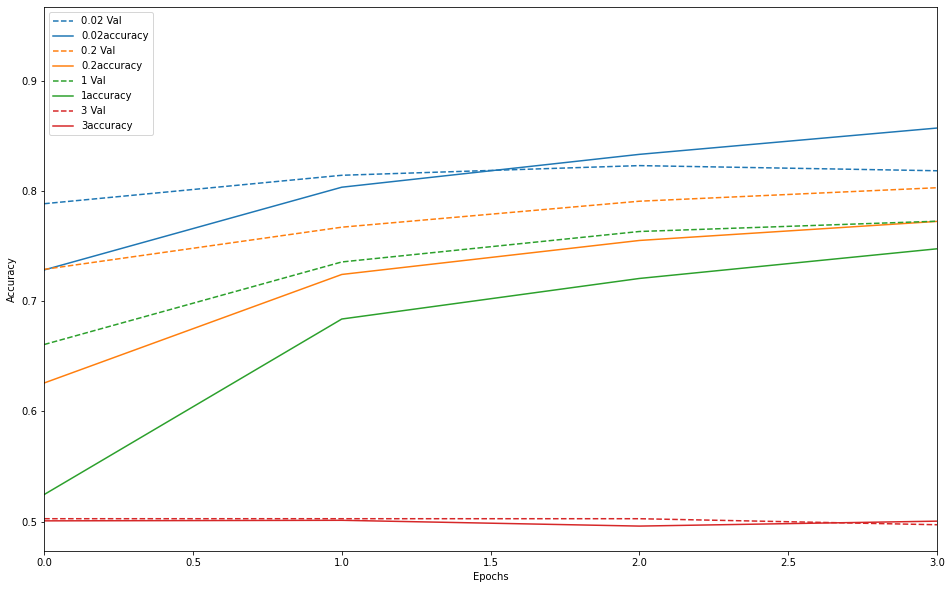

In [29]:
plot_history([('0.02', max_len_fifty_history),
              ('0.2', l2_0_2_history),
              ('1', l2_1_history),
              ('3', l2_3_history)])

# 필터값 변경

## filter = 3, 4, 5, 6, 7

In [30]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,4,5,6,7]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
# l2 규제를 조절
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_5_model = tf.keras.Model(sequence_input, output)
filter_5_model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 50, 300)      14157600    input_7[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 50, 128)      115328      embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 50, 128)      153728      embedding_6[0][0]                
______________________________________________________________________________________

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_5_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_5_history = filter_5_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.6050 - accuracy: 0.7365 - val_loss: 0.5503 - val_accuracy: 0.7876
Epoch 2/10
3750/3750 [==============================] - 27s 7ms/step - loss: 0.5462 - accuracy: 0.8048 - val_loss: 0.5771 - val_accuracy: 0.7897
Epoch 3/10
3750/3750 [==============================] - 26s 7ms/step - loss: 0.5257 - accuracy: 0.8348 - val_loss: 0.5446 - val_accuracy: 0.8251
Epoch 4/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.5088 - accuracy: 0.8619 - val_loss: 0.5744 - val_accuracy: 0.8228
Epoch 5/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.4919 - accuracy: 0.8853 - val_loss: 0.5971 - val_accuracy: 0.8263
Epoch 6/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.4693 - accuracy: 0.9073 - val_loss: 0.6358 - val_accuracy: 0.8272
Epoch 7/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.4496 - accuracy: 0.9238 - val_loss: 0.6678 - val_ac

## filter = 3, 5, 7

In [32]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [3,5,7]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_357_model = tf.keras.Model(sequence_input, output)
filter_357_model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 50, 300)      14157600    input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 50, 128)      115328      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 50, 128)      192128      embedding_7[0][0]                
______________________________________________________________________________________

In [33]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_357_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_357_history = filter_357_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.6006 - accuracy: 0.7228 - val_loss: 0.5329 - val_accuracy: 0.7830
Epoch 2/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.5157 - accuracy: 0.8014 - val_loss: 0.4931 - val_accuracy: 0.8172
Epoch 3/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4846 - accuracy: 0.8341 - val_loss: 0.4971 - val_accuracy: 0.8231
Epoch 4/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4628 - accuracy: 0.8572 - val_loss: 0.5041 - val_accuracy: 0.8266
Epoch 5/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4354 - accuracy: 0.8807 - val_loss: 0.5656 - val_accuracy: 0.8117
Epoch 6/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.4126 - accuracy: 0.9013 - val_loss: 0.5856 - val_accuracy: 0.8210
Epoch 7/10
3750/3750 [==============================] - 16s 4ms/step - loss: 0.3866 - accuracy: 0.9193 - val_loss: 0.6193 - val_ac

## filter = 1, 2, 3

In [34]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [1,2,3]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_123_model = tf.keras.Model(sequence_input, output)
filter_123_model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 50, 300)      14157600    input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_26 (Conv1D)              (None, 50, 128)      38528       embedding_8[0][0]                
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 50, 128)      76928       embedding_8[0][0]                
______________________________________________________________________________________

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_123_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_123_history = filter_123_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.6037 - accuracy: 0.7354 - val_loss: 0.5348 - val_accuracy: 0.7994
Epoch 2/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5319 - accuracy: 0.8060 - val_loss: 0.5112 - val_accuracy: 0.8172
Epoch 3/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.5128 - accuracy: 0.8289 - val_loss: 0.5204 - val_accuracy: 0.8277
Epoch 4/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4980 - accuracy: 0.8467 - val_loss: 0.5188 - val_accuracy: 0.8326
Epoch 5/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4878 - accuracy: 0.8598 - val_loss: 0.5328 - val_accuracy: 0.8254
Epoch 6/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4777 - accuracy: 0.8724 - val_loss: 0.5385 - val_accuracy: 0.8281
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 0.4630 - accuracy: 0.8845 - val_loss: 0.5819 - val_ac

## filter = 4, 5, 6

In [36]:
sequence_input = tf.keras.Input(shape=(max_len,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            input_length=max_len,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)


convs = []
#각각의 N-gram을 통해 생성된 layer를 담는 곳
filter_sizes = [4,5,6]
#filter_size는 N-gram에서의 N을 결정

for fsz in filter_sizes:
    x = tf.keras.layers.Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
#3,4,5의 N-gram을 통해 생성된 layer를 하나의 레이어로 통합 
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#해당 리뷰가 긍정인지, 부정인지를 결정하는 2진 함수이기에 sigmoid 적용
filter_456_model = tf.keras.Model(sequence_input, output)
filter_456_model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 50, 300)      14157600    input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 50, 128)      153728      embedding_9[0][0]                
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 50, 128)      192128      embedding_9[0][0]                
______________________________________________________________________________________

In [37]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
#val_accuracy가 감소하게 되면 자동으로 epoch를 멈추는 earlystopping 사용

filter_456_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

filter_456_history = filter_456_model.fit(X_train, y_train, epochs = 10, validation_split=0.2, callbacks=[callback])

Epoch 1/10
3750/3750 [==============================] - 17s 5ms/step - loss: 0.5990 - accuracy: 0.7270 - val_loss: 0.5281 - val_accuracy: 0.7859
Epoch 2/10
3750/3750 [==============================] - 17s 5ms/step - loss: 0.5224 - accuracy: 0.7984 - val_loss: 0.5107 - val_accuracy: 0.8096
Epoch 3/10
3750/3750 [==============================] - 17s 5ms/step - loss: 0.4934 - accuracy: 0.8320 - val_loss: 0.5108 - val_accuracy: 0.8173
Epoch 4/10
3750/3750 [==============================] - 17s 4ms/step - loss: 0.4692 - accuracy: 0.8580 - val_loss: 0.5422 - val_accuracy: 0.8221
Epoch 5/10
3750/3750 [==============================] - 17s 5ms/step - loss: 0.4470 - accuracy: 0.8796 - val_loss: 0.5836 - val_accuracy: 0.8158
Epoch 6/10
3750/3750 [==============================] - 17s 5ms/step - loss: 0.4232 - accuracy: 0.9011 - val_loss: 0.6032 - val_accuracy: 0.8104
Epoch 7/10
3750/3750 [==============================] - 17s 5ms/step - loss: 0.3974 - accuracy: 0.9196 - val_loss: 0.6556 - val_ac

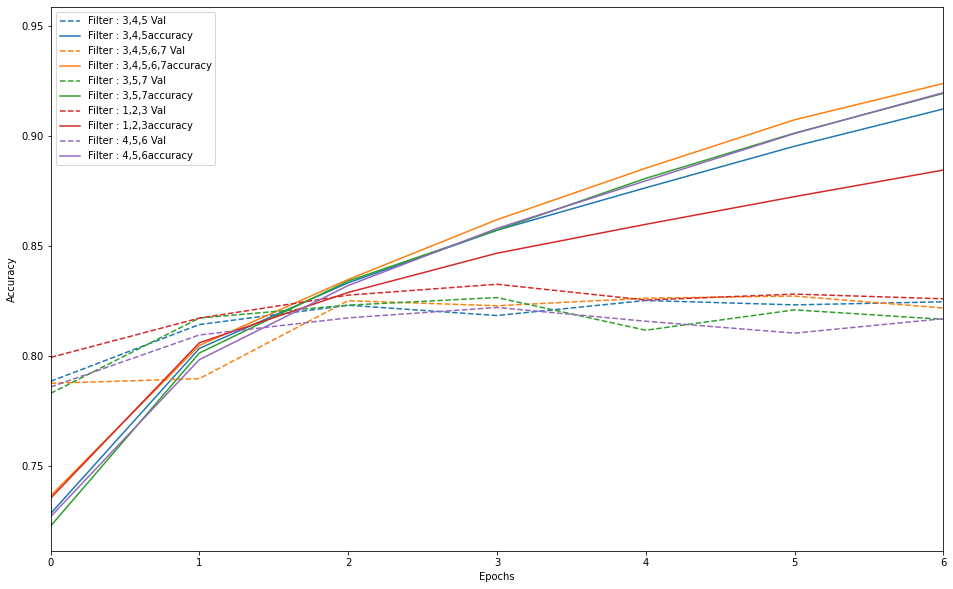

In [38]:
plot_history([('filter : 3,4,5', max_len_fifty_history),
              ('filter : 3,4,5,6,7', filter_5_history),
              ('filter : 3,5,7', filter_357_history),
              ('filter : 1,2,3', filter_123_history),
              ('filter : 4,5,6', filter_456_history),
             ])

# 예측

In [39]:
clean_doc[10:20]

['걍 인피니트 짱 진짜 짱 ♥',
 '볼때 눈물나다 죽다 90년 대의 향수 자극 허진호 감성 절제 멜로 달인',
 '울면 손 횡단보도 건너다 뛰다 치다 올 뻔 이범수 연기 드럽다 못 하다',
 '담백하다 깔끔하다 좋다 신 문 기 사 로만 보다 보다 자꾸 잊어버리다 이다',
 '취향 존중 다지 진짜 내생 극장 보다 영화 중 가장 노잼 노 감동 임 스토리 어거지 감동 어거지',
 'ㄱ 냥 매번 긴장 되다 재밋음 ㅠㅠ',
 '차다 웃기다 바스코 이기 락스 코 끄다 바비 이기 아이돌 깔다 그냥 끄다 안달 보이다',
 '굿바이 레닌 표절 이해 하다 왜 뒤 갈수록 재미 없어지다',
 '이건 정말 깨알 캐스팅 질퍽 않다 산뜻하다 내 용구성 자다 버무러진 깨알 일드 ♥',
 '약탈 자 위 변명 이르다 저 놈 착하다 놈 절대 아니다 걸']

In [40]:
sentence = ['짱', '존나', '재미', 'ㅋㅋㅋㅋ', doc[4]]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_len, padding = 'post', truncating= 'post')
print(model.predict(padded_exp).round(2))

NameError: name 'model' is not defined

# 데이터 저장과 불러오기

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model') 

new_model = tf.keras.models.load_model('saved_model/my_model')